In [97]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from yome import Session
from yome.models import *
from yome.util import to_df, report
import re
from sqlalchemy import exists, distinct
from sqlalchemy.orm import aliased

%mpl_setup

sns.set_style('ticks')

session = Session()

Populating the interactive namespace from numpy and matplotlib


# Load IterativeWCGNA modules

In [2]:
df = pd.read_table('../data/wgcna-membership-minmod10-2018-11-13.tsv', sep='\t')

In [3]:
df.head()

,Gene,Module,kME
0,b0002,UNCLASSIFIED,NaN
1,b0003,UNCLASSIFIED,NaN
2,b0004,UNCLASSIFIED,NaN
3,b0005,UNCLASSIFIED,NaN
4,b0006,UNCLASSIFIED,NaN


# Load expression data

In [150]:
tpm_log = pd.read_table('../data/precise/tpm-log.tsv', sep='\t', index_col='locus_tag')

# TODOs
- get gene names & ecocyc descriptions for all genes in each module
- plot correlation for a couple examples to confirm groups
- try clustering on log expression
- read interativeWGCNA & WGCNA papers
  + https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html

# get gene names & descriptions

In [5]:
# List EcoCyc feature types
(session.query(distinct(KnowledgebaseFeature.feature_type))
 .join(KnowledgebaseGene)
 .join(Knowledgebase)
 .filter(Knowledgebase.name == 'EcoCyc')).all()

[('summary_html'),
 ('product_type'),
 ('is_pseudogene'),
 ('is_phantom_gene'),
 ('is_insertion_element'),
 ('description'),
 ('evidence_html'),
 ('component_html'),
 ('ec_number'),
 ('reaction_equation')]

In [6]:
# EcoCyc descriptions
ec = to_df((
    session.query(Gene.locus_id, 
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoCyc')
    .filter(KnowledgebaseFeature.feature_type == 'description')
).all(), ['locus_tag', 'primary_name', 'description'])

In [7]:
ec.head()

,locus_tag,primary_name,description
0,b4584,rpnD,truncated recombination-promoting nuclease-lik...
1,b3328,gspG,Type II secretion system protein GspG
2,b1001,yccE,uncharacterized protein YccE
3,b2467,nudK,GDP-mannose hydrolase
4,b3549,tag,"3-methyl-adenine DNA glycosylase I, constitutive"


# Get Y-ome annotations

In [32]:
yome_genes = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.annotation_quality)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'Y-ome')
).rename(columns={'locus_id': 'locus_tag'})

# Join to clusters

In [33]:
clusters = df.rename(columns={'Gene': 'locus_tag'}).merge(ec).merge(yome_genes)

In [34]:
g_clusters = clusters.groupby('Module')

In [35]:
# cluster size
# g_clusters['locus_tag'].agg(len).sort_values(ascending=False)

In [63]:
for name, group in g_clusters:
    print(name, len(group))
    display(group.sort_values('kME', ascending=False).head())
    break

P1_I7_M1 117


,locus_tag,Module,kME,primary_name,description,annotation_quality
1817,b2131,P1_I7_M1,0.97,osmF,glycine betaine ABC transporter periplasmic bi...,high
3639,b4269,P1_I7_M1,0.96,ahr,"aldehyde reductase, NADPH-dependent",high
1823,b2137,P1_I7_M1,0.96,yohF,putative oxidoreductase with NAD(P)-binding Ro...,low
674,b0808,P1_I7_M1,0.96,ybiO,moderate conductance mechanosensitive channel,high
678,b0812,P1_I7_M1,0.96,dps,Dps complex; stationary phase nucleoid compone...,high


# Get number of genes by annotation quality in each group

In [82]:
clusters.annotation_quality.value_counts().get('high')

2545

In [126]:
def high(x): 
    return x.value_counts().get('high')
def low(x):
    return x.value_counts().get('low')
def excluded(x):
    return x.value_counts().get('excluded')
quality_counts = pd.DataFrame(g_clusters.annotation_quality.agg([high, low, excluded])).fillna(0)
quality_counts['size'] = quality_counts.sum(axis=1)
quality_counts.sort_values('size', ascending=False, inplace=True)
quality_counts = quality_counts.astype(int)

In [127]:
quality_counts.head()

,high,low,excluded,size
Module,,,,
UNCLASSIFIED,1764,868,38,2670
P1_I7_M1,67,49,0,116
P1_I7_M2,41,31,0,72
P1_I7_M4,44,14,0,58
P1_I7_M3,29,25,2,56


Text(0,0.5,'Number of genes')

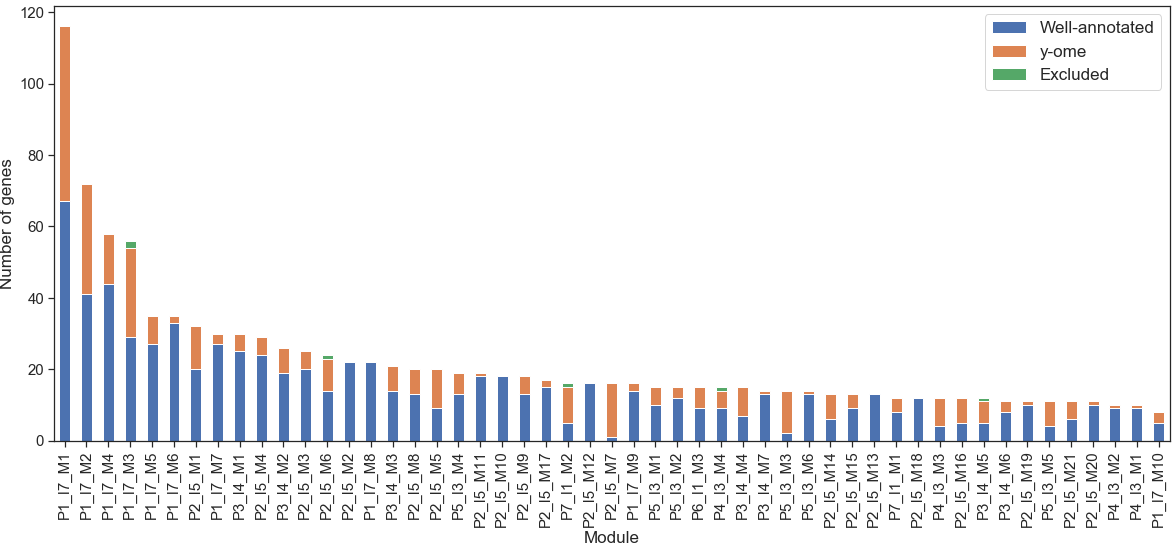

In [132]:
fig, ax = plt.subplots(figsize=(20, 8))
(quality_counts
 .drop('UNCLASSIFIED')
 .drop('size', axis=1)
 .rename(columns={'high': 'Well-annotated', 'low': 'y-ome', 'excluded': 'Excluded'})
 .plot(kind='bar', stacked=True, ax=ax))
ax.set_ylabel('Number of genes')

## highest y-ome percentage

In [135]:
quality_counts['yome_fraction'] = quality_counts.low / quality_counts['size']

In [141]:
quality_counts.sort_values('yome_fraction', ascending=True).head()

,high,low,excluded,size,yome_fraction
Module,,,,,
P2_I5_M12,16,0,0,16,0.0
P2_I5_M10,18,0,0,18,0.0
P2_I5_M13,13,0,0,13,0.0
P1_I7_M8,22,0,0,22,0.0
P2_I5_M2,22,0,0,22,0.0


In [140]:
quality_counts.sort_values('yome_fraction', ascending=False).head()

,high,low,excluded,size,yome_fraction
Module,,,,,
P2_I5_M7,1,15,0,16,0.937500
P5_I3_M3,2,12,0,14,0.857143
P4_I3_M3,4,8,0,12,0.666667
P5_I3_M5,4,7,0,11,0.636364
P7_I1_M2,5,10,1,16,0.625000


In [145]:
# check out this stress cluster!
g_clusters.get_group('P2_I5_M7').sort_values('kME', ascending=False)

,annotation_quality,description,kME,locus_tag,primary_name
1459,low,protein YdiZ,0.94,b1724,ydiZ
2747,low,putative barnase inhibitor,0.93,b3239,yhcO
862,low,PF13993 family protein YccJ,0.91,b1003,yccJ
1568,low,protein YebV,0.91,b1836,yebV
368,high,DNA-binding transcriptional dual regulator BolA,0.91,b0435,bolA
1022,low,PF04226 family protein YmgE,0.90,b1195,ymgE
3021,low,putative DNA-binding transcriptional regulator...,0.90,b3555,yiaG
1938,low,tail anchored inner membrane protein,0.90,b2266,elaB
273,low,DUF1471 domain-containing protein YahO,0.89,b0329,yahO
2964,low,putative universal stress (ethanol tolerance) ...,0.89,b3494,uspB


In [157]:
pd.DataFrame(tpm_log.loc['b1724'].T.sort_values(ascending=False)).head(10)

,b1724
fur__delfur_dpd__2,9.040378
ompr__bw_delompr_nacl__1,8.926135
ompr__bw_delompr_nacl__2,8.820648
ompr__wt_nacl__1,8.811954
oxidative__delsoxs_pq__1,8.719523
oxidative__delsoxs_pq__2,8.637806
fur__wt_dpd__2,8.629453
ica__gth__1,8.598319
fur__wt_dpd__1,8.428337
oxidative__wt_pq__1,8.416995


# Check in expression set

In [13]:
exp = pd.read_table('../data/precise/tpm-log.tsv', sep='\t', index_col='locus_tag')

In [14]:
exp.head()

,base__wt_glc__1,base__wt_glc__2,fur__wt_dpd__1,fur__wt_dpd__2,fur__wt_fe__1,fur__wt_fe__2,fur__delfur_dpd__1,fur__delfur_dpd__2,fur__delfur_fe2__1,fur__delfur_fe2__2,...,ica__no3_anaero__1,ica__no3_anaero__2,ica__phe_acgam__1,ica__phe_acgam__2,ica__thm_gal__1,ica__thm_gal__2,ica__tyr_glcn__1,ica__tyr_glcn__2,ica__ura_pyr__1,ica__ura_pyr__2
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,11.006777,11.130303,11.705085,11.888364,11.064951,10.779232,9.976561,10.291286,11.229957,11.214245,...,10.996845,10.960625,10.571880,10.691763,11.092842,11.088388,10.965285,11.098627,11.484893,11.510086
b0003,10.415779,10.523245,11.423968,11.803928,10.777126,10.597971,9.596992,10.191653,10.898128,10.861337,...,10.474725,10.444165,9.860882,9.964103,10.394186,10.411429,10.378227,10.410986,10.783076,10.883341
b0004,10.594996,10.725169,10.457404,10.779308,10.395113,10.114110,8.741777,9.082381,10.185341,10.164834,...,10.585274,10.602996,10.255297,10.345638,10.602078,10.665230,10.708844,10.795653,11.071328,11.232304
b0005,6.316225,6.258604,5.422259,5.336264,6.716210,6.411023,4.627102,4.756298,6.527841,6.136345,...,5.505363,5.242289,5.160180,5.177222,4.513065,4.859350,5.810963,5.597134,6.300981,5.624121
b0006,6.915894,6.897703,6.775777,6.782750,6.761954,6.816691,6.686925,6.860185,6.862335,6.817658,...,7.159796,7.073032,6.940665,6.834027,6.723969,6.604129,6.940588,6.793061,6.966130,6.998164


In [15]:
top2 = exp[exp.index.isin(['b4269', 'b2131'])].iloc[:, 1:].T

In [16]:
top2.head()

locus_tag,b2131,b4269
base__wt_glc__2,6.199009,6.222521
fur__wt_dpd__1,8.434535,8.530602
fur__wt_dpd__2,8.604036,8.561050
fur__wt_fe__1,5.759786,5.790031
fur__wt_fe__2,5.541524,5.646463


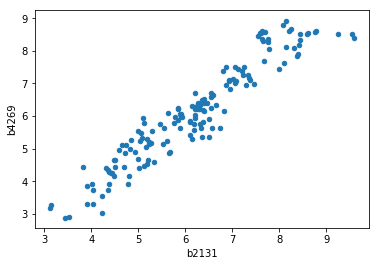

In [18]:
top2.plot(x='b2131', y='b4269', kind='scatter')

In [19]:
top2.corr()

locus_tag,b2131,b4269
locus_tag,,
b2131,1.000000,0.950706
b4269,0.950706,1.000000
